In [1]:
# Load necessary libraries
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller    # For ADF test
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.metrics import make_scorer, mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit
from scipy.stats import norm 
from scipy.stats import uniform, loguniform                    
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
## Algorithm 1 & 2: Data Preparation and Quarterly Aggregation of Variables

# 1. Load the master dataset
df = pd.read_csv('master_UK.csv')

# 2. Parse the DATE column and create a quarter identifier
df['DATE'] = pd.to_datetime(df['DATE'])
df['quarter'] = df['DATE'].dt.to_period('Q')

# 3. Specify the target variable name
Y_col = 'Real GDP' 

# 5. Identify explanatory variables (exclude DATE, quarter, and Y column)
exclude_cols = {'DATE', 'quarter', Y_col}
x_cols = [col for col in df.columns if col not in exclude_cols]

# 6. Run ADF test for each explanatory variable
adf_results = pd.DataFrame(columns=["Variable", "ADF Statistic", "p-value", "Stationary at 5%"])
X_prime_m_df = df[['DATE', 'quarter']].copy()  

for col in x_cols:
    series_original = df[col].copy()
    series_numeric = pd.to_numeric(series_original, errors='coerce').dropna()

    if not series_numeric.empty:
        result = adfuller(series_numeric)
        adf_stat = result[0]
        p_value = result[1]
        is_stationary = p_value < 0.05
        adf_results.loc[len(adf_results)] = [col, adf_stat, p_value, is_stationary]
    else:
        adf_results.loc[len(adf_results)] = [col, np.nan, np.nan, False]

# Display ADF test results
adf_results_display = adf_results.set_index("Variable").sort_values("p-value")
print("\n=== ADF Test Results ===")
print(adf_results_display)



=== ADF Test Results ===
                ADF Statistic   p-value  Stationary at 5%
Variable                                                 
Unemp               -2.344865  0.157906             False
Intr_10Y            -2.307156  0.169671             False
Intr_Rate           -2.304371  0.170562             False
Exchange            -2.210765  0.202362             False
Prod_Vol            -2.133070  0.231427             False
Emp                 -1.758801  0.401099             False
Share_Prices        -1.698398  0.431938             False
^FTSE               -1.698110  0.432086             False
Exports             -1.047389  0.735591             False
Imports             -0.661254  0.856532             False
Total Reserves      -0.018655  0.956962             False
M1                   1.460088  0.997371             False
CPI                  1.992342  0.998663             False


/var/folders/1b/b3lsjhy10fsd753tw_292d5w0000gn/T/ipykernel_35569/2081229211.py:7: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['DATE'] = pd.to_datetime(df['DATE'])


In [3]:
# 7. Manually specify which X columns should be log-differenced
log_diff_cols = [
'Unemp',              
'Intr_10Y',            
'Intr_Rate',           
'Exchange',            
'Prod_Vol',            
'Emp',                
'Share_Prices',        
'^FTSE',               
'Exports',            
'Imports',            
'Total Reserves',     
'M1',                   
'CPI'
]

# 8. Identify explanatory variables that are not log-differenced
non_log_cols = [col for col in x_cols if col not in log_diff_cols]

# 9. Apply transformation to create X_prime_m_df (transformed monthly X)
for col in x_cols:
    if col in log_diff_cols:
        if (df[col] <= 0).any():
            print(f"Warning: Column {col} contains non-positive values. Applying log.diff() may result in NaNs or errors.")
            try:
                X_prime_m_df[col] = np.log(df[col].replace(0, np.nan)).diff()
            except Exception as e:
                print(f"Error log-differencing {col}: {e}. Column will be NaN.")
                X_prime_m_df[col] = np.nan
        else:
            X_prime_m_df[col] = np.log(df[col]).diff()
    else:
        X_prime_m_df[col] = df[col].copy()

# 10. Group the transformed monthly X by quarter
quarter_groups_X_prime = X_prime_m_df.groupby('quarter')

# 11. For log-differenced variables, take the quarterly sum
x_q_aggregated_log = quarter_groups_X_prime[log_diff_cols].sum() if log_diff_cols else pd.DataFrame(index=quarter_groups_X_prime.size().index)

# 12. For non-log-differenced variables, take the quarterly mean
x_q_aggregated_nonlog = quarter_groups_X_prime[non_log_cols].mean() if non_log_cols else pd.DataFrame(index=quarter_groups_X_prime.size().index)

# 13. Combine aggregated quarterly explanatory variables
X_q_aggregated = pd.concat([x_q_aggregated_log, x_q_aggregated_nonlog], axis=1).sort_index()

# 14. Extract quarterly target observations (use the first month of each quarter)
y_q_levels_df = (
    df[df[Y_col].notna()][['quarter', Y_col]]
    .drop_duplicates(subset='quarter', keep='first')  
    .set_index('quarter')
    .sort_index()
)

# 15. Align aggregated X with quarterly Y
common_index = X_q_aggregated.index.intersection(y_q_levels_df.index)
X_q_aligned = X_q_aggregated.loc[common_index]
Y_q_levels = y_q_levels_df.loc[common_index, Y_col]

# 16. Convert Y to quarterly log difference (growth rate)
Y_q_processed = np.log(Y_q_levels).diff().dropna()

# 17. Align X again with the log-differenced Y (drops one more quarter)
X_q_processed = X_q_aligned.loc[Y_q_processed.index]

# Display
print("\n--- Final Processed Data (Before Train/Test Split, No scaling for non-log) ---")
print("Processed Quarterly X shape:", X_q_processed.shape)
print("Processed Quarterly Y shape:", Y_q_processed.shape)
print("\nX_q_processed (first few rows):")
print(X_q_processed.head())
print("\nY_q_processed (first few rows):")
print(Y_q_processed.head())


--- Final Processed Data (Before Train/Test Split, No scaling for non-log) ---
Processed Quarterly X shape: (132, 13)
Processed Quarterly Y shape: (132,)

X_q_processed (first few rows):
            Unemp  Intr_10Y  Intr_Rate  Exchange  Prod_Vol       Emp  \
quarter                                                                
1991Q2   0.070618  0.027793   0.027793 -0.099012  0.001375 -0.011252   
1991Q3   0.055263 -0.093044  -0.093044  0.045503 -0.018019 -0.008523   
1991Q4   0.021277  0.002073   0.002073  0.056689  0.011127 -0.007158   
1992Q1   0.031091  0.002068   0.002068 -0.058254  0.001382 -0.004320   
1992Q2   0.010152 -0.059592  -0.059592  0.073407 -0.004152 -0.004338   

         Share_Prices     ^FTSE   Exports   Imports  Total Reserves        M1  \
quarter                                                                         
1991Q2       0.018334  0.018345  0.037153  0.005525        0.024657  0.028145   
1991Q3       0.049656  0.049656 -0.015311 -0.004241        0.054

In [4]:
## Algorithm 3: Hyperparameter Tuning and Initial Estimation

np.random.seed(42)  # For reproducibility

# 1. Train/Test Split
split_idx = int(len(X_q_processed) * 0.8)
X_q_train = X_q_processed.iloc[:split_idx]
Y_q_train = Y_q_processed.iloc[:split_idx]
X_q_test = X_q_processed.iloc[split_idx:]
Y_q_test = Y_q_processed.iloc[split_idx:]

# Standardize non-log-differenced columns
scaler = StandardScaler()
X_q_train_scaled = X_q_train.copy()
X_q_test_scaled = X_q_test.copy()
if non_log_cols:
    X_q_train_scaled[non_log_cols] = scaler.fit_transform(X_q_train[non_log_cols])
    X_q_test_scaled[non_log_cols] = scaler.transform(X_q_test[non_log_cols])

# 2. Convert to numpy arrays
X = X_q_train.values
y = Y_q_train.values

# 1. Define ElasticNet model
model = ElasticNet(max_iter=20000, tol=1e-9)

# 2. Define hyperparameter distributions for Randomized Search
param_distributions = {
    'alpha': loguniform(1e-6, 100),
    'l1_ratio': uniform(0.001, 0.999)
}

# 3. Set up blocked time-series cross-validation
tscv = TimeSeriesSplit(n_splits=5)

# 4. Define MSE-based scoring function
mse_scorer = make_scorer(mean_squared_error, greater_is_better=False)

# 5. Run Randomized Search with cross-validation
random_search = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_distributions,
    n_iter=200,  
    scoring=mse_scorer,
    cv=tscv,
    n_jobs=-1,
    random_state=42
)
random_search.fit(X, y)

# 6. Extract optimal hyperparameters and other results
best_params = random_search.best_params_
alpha_star = best_params['alpha']
l1_ratio_star = best_params['l1_ratio']
lambda_1_star = alpha_star * l1_ratio_star
lambda_2_star = alpha_star * (1 - l1_ratio_star)
best_estimator = random_search.best_estimator_
train_mse = -random_search.best_score_
y_pred_train = best_estimator.predict(X)
train_r2 = r2_score(y, y_pred_train)

# 7. Print results
print(f"Best parameters found: {best_params}")
print(f"Mapped λ₁ (L1 penalty): {lambda_1_star:.6f}")
print(f"Mapped λ₂ (L2 penalty): {lambda_2_star:.6f}")
print(f"Train CV MSE: {train_mse:.6f}")
print(f"Train R²: {train_r2:.6f}")
print(f"Number of iterations to converge: {best_estimator.n_iter_}")
print(f"Estimated coefficients: {best_estimator.coef_}")

/Users/yonggeun/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.397e-12, tolerance: 3.163e-13
  model = cd_fast.enet_coordinate_descent(
/Users/yonggeun/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.256e-10, tolerance: 3.163e-13
  model = cd_fast.enet_coordinate_descent(
/Users/yonggeun/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasi

Best parameters found: {'alpha': np.float64(3.6840802202042715e-05), 'l1_ratio': np.float64(0.0702919395742903)}
Mapped λ₁ (L1 penalty): 0.000003
Mapped λ₂ (L2 penalty): 0.000034
Train CV MSE: 0.000024
Train R²: 0.592276
Number of iterations to converge: 945
Estimated coefficients: [-0.07901599  0.          0.00066304  0.02392988  0.04529479  0.
  0.00662334  0.00842084  0.01676768  0.01990798 -0.00093918  0.03465235
 -0.01102039]


/Users/yonggeun/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.583e-12, tolerance: 9.128e-13
  model = cd_fast.enet_coordinate_descent(
/Users/yonggeun/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.559e-10, tolerance: 3.163e-13
  model = cd_fast.enet_coordinate_descent(
/Users/yonggeun/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasi

In [5]:
# 1. Bootstrap settings
B = 50000
beta_hat_bootstrap_list = []

# 2. Run B bootstrap iterations
for _ in tqdm(range(B)):
    indices = np.random.choice(len(X), size=len(X), replace=True)
    X_b = X[indices]
    y_b = y[indices]

    model_b = ElasticNet(alpha=alpha_star, l1_ratio=l1_ratio_star, max_iter=10000, tol=1e-5)
    model_b.fit(X_b, y_b)
    beta_hat_bootstrap_list.append(model_b.coef_)

# 3. Compute statistics for coefficients
beta_hat_array = np.array(beta_hat_bootstrap_list)
beta_hat_final = beta_hat_array.mean(axis=0)
beta_ci_lower = np.percentile(beta_hat_array, 2.5, axis=0)
beta_ci_upper = np.percentile(beta_hat_array, 97.5, axis=0)

# Standard error is the standard deviation of the bootstrap estimates
beta_se = np.std(beta_hat_array, axis=0)

# Calculate z-scores, avoiding division by zero for coefficients that are always zero
z_scores = np.divide(beta_hat_final, beta_se, out=np.zeros_like(beta_hat_final), where=(beta_se != 0))

# Calculate p-values from z-scores (two-tailed test)
p_values = 2 * (1 - norm.cdf(np.abs(z_scores)))

# 3.6. Create and save a DataFrame with detailed coefficient statistics
beta_results_df = pd.DataFrame({
    'Variable': X_q_train.columns,
    'Coefficient': beta_hat_final,
    'Lower_CI_95': beta_ci_lower,
    'Upper_CI_95': beta_ci_upper,
    'P_Value': p_values
})

# Save the results table to a CSV file
beta_results_df.to_csv("UK_elastic_net_bootstrap_coefficients.csv", index=False)
print("\nBootstrap coefficient results saved to 'UK_elastic_net_bootstrap_coefficients.csv'")

# 4. Predict monthly GDP estimates
X_m = X_prime_m_df[X_q_train.columns].values
y_m_pred = X_m @ beta_hat_final

# 5. Confidence intervals for predictions
y_m_bootstrap_preds = beta_hat_array @ X_m.T  # shape: (B, num_months)
y_m_lower = np.percentile(y_m_bootstrap_preds, 2.5, axis=0)
y_m_upper = np.percentile(y_m_bootstrap_preds, 97.5, axis=0)

# 6. Output: Beta table with CIs
print("\n=== Estimated Coefficients with 95% CI ===")
for i, col in enumerate(X_q_train.columns):
    b = beta_hat_final[i]
    lb = beta_ci_lower[i]
    ub = beta_ci_upper[i]
    print(f"{col:20s}: {b: .6f}  [{lb: .6f}, {ub: .6f}]")

# 7. Output: Monthly GDP estimates (first few rows)
print("\n--- Monthly GDP Estimates and Confidence Intervals (first 5 months) ---")
for i in range(10):
    print(f"Month {i+1}: {y_m_pred[i]: .6f}  [{y_m_lower[i]: .6f}, {y_m_upper[i]: .6f}]")

# 8. Output: Training metrics
print("\n--- Model Performance ---")
print(f"Train CV MSE: {train_mse:.6f}")
print(f"Train R²: {train_r2:.6f}")


100%|██████████| 50000/50000 [00:28<00:00, 1759.96it/s]



Bootstrap coefficient results saved to 'UK_elastic_net_bootstrap_coefficients.csv'

=== Estimated Coefficients with 95% CI ===
Unemp               : -0.075896  [-0.101728, -0.045632]
Intr_10Y            : -0.000284  [-0.003819,  0.002564]
Intr_Rate           :  0.001313  [-0.000657,  0.006095]
Exchange            :  0.022349  [ 0.000000,  0.044813]
Prod_Vol            :  0.039932  [ 0.000000,  0.084508]
Emp                 :  0.000636  [ 0.000000,  0.009931]
Share_Prices        :  0.006334  [ 0.000000,  0.017208]
^FTSE               :  0.008223  [ 0.000000,  0.020987]
Exports             :  0.016188  [ 0.001458,  0.033960]
Imports             :  0.017896  [-0.001023,  0.042977]
Total Reserves      : -0.001517  [-0.017976,  0.013927]
M1                  :  0.032702  [ 0.003491,  0.058539]
CPI                 : -0.018301  [-0.071325,  0.000000]

--- Monthly GDP Estimates and Confidence Intervals (first 5 months) ---
Month 1:  nan  [ nan,  nan]
Month 2: -0.002192  [-0.004598,  0.000231]



[Model Evaluation on Test Set]
Test MSE: 0.002959
Test RMSE: 0.054400
Test MAE: 0.021520
Test R²: 0.030
Sign Accuracy: 55.56%
sMAPE: 137.12%
Theil's U1: 0.900

'test_ENET.csv' saved.
'test_ENET_UK_summary_metrics.csv' saved.


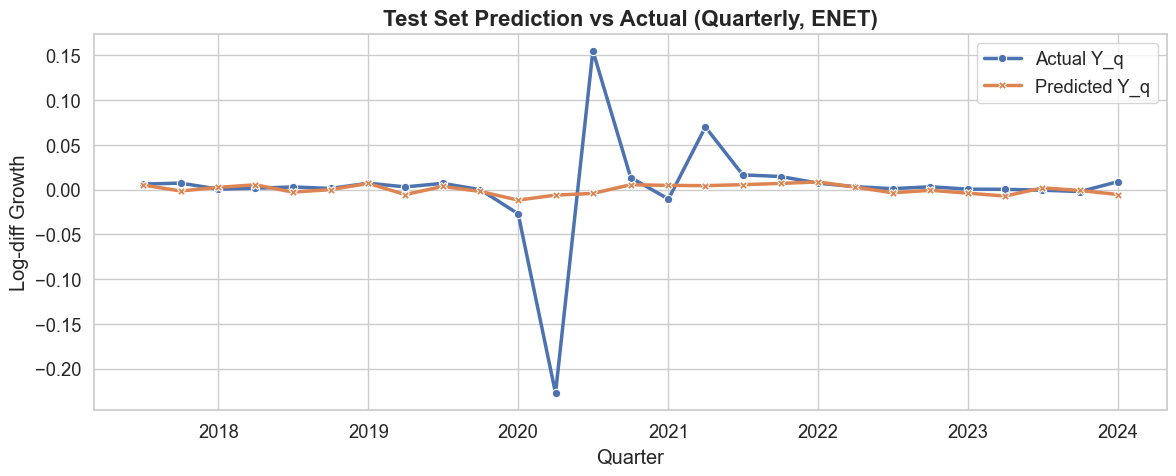

In [ ]:
# TEST SET EVALUATION
X_test = X_q_test_scaled.values
y_test = Y_q_test.values

# 2. Predict using final bootstrap-averaged coefficients
y_test_pred = X_test @ beta_hat_final

# Define functions for sMAPE and Theil's U1
def smape(y_true, y_pred):
    """Symmetric Mean Absolute Percentage Error"""
    numerator = 2 * np.abs(y_pred - y_true)
    denominator = np.abs(y_true) + np.abs(y_pred)
    ratio = np.divide(numerator, denominator, out=np.zeros_like(numerator, dtype=float), where=denominator!=0)
    return np.mean(ratio) * 100

def theil_u1(y_true, y_pred):
    """Theil's U1 statistic for forecast accuracy"""
    rmse = np.sqrt(np.mean((y_true - y_pred)**2))
    rms_actual = np.sqrt(np.mean(y_true**2))
    rms_pred = np.sqrt(np.mean(y_pred**2))
    if (rms_actual + rms_pred) == 0:
        return np.nan
    return rmse / (rms_actual + rms_pred)

# Calculate all metrics
mse = mean_squared_error(y_test, y_test_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_test_pred)
r2 = r2_score(y_test, y_test_pred)
sign_acc = (np.sign(y_test_pred) == np.sign(y_test)).mean()
smape_val = smape(y_test, y_test_pred)
theil_u1_val = theil_u1(y_test, y_test_pred)

# Print all metrics
print("\n[Model Evaluation on Test Set]")
print(f"Test MSE: {mse:.6f}")
print(f"Test RMSE: {rmse:.6f}")
print(f"Test MAE: {mae:.6f}")
print(f"Test R²: {r2:.3f}")
print(f"Sign Accuracy: {sign_acc:.2%}")
print(f"sMAPE: {smape_val:.2f}%")
print(f"Theil's U1: {theil_u1_val:.3f}")

# Create a DataFrame for per-prediction results
results_index = Y_q_test.index
results_df = pd.DataFrame({
    "Quarter": results_index.to_timestamp(),
    "Actual_Y_q": y_test,
    "Predicted_Y_q": y_test_pred,
    "Sign_Match": (np.sign(y_test_pred) == np.sign(y_test)).astype(int)
})
results_df.to_csv("test_ENET_UK.csv", index=False)
print("\n'test_ENET.csv' saved.")

# Create and save a DataFrame for the summary metrics
metrics_summary_df = pd.DataFrame({
    'Metric': ['MSE', 'RMSE', 'MAE', 'R2', 'Sign Accuracy', 'sMAPE', 'Theil U1'],
    'Value': [mse, rmse, mae, r2, sign_acc, smape_val, theil_u1_val]
})
metrics_summary_df.to_csv("test_ENET_UK_summary_metrics.csv", index=False)
print("'test_ENET_UK_summary_metrics.csv' saved.")

# 5. Plot actual vs predicted on test se
sns.set_theme(style="whitegrid", font_scale=1.2, rc={"lines.linewidth": 2.5})
plt.figure(figsize=(12, 5))
sns.lineplot(x=Y_q_test.index.to_timestamp(), y=y_test, label="Actual Y_q", marker="o")
sns.lineplot(x=Y_q_test.index.to_timestamp(), y=y_test_pred, label="Predicted Y_q", marker="X")
plt.title("Test Set Prediction vs Actual (Quarterly, ENET)", fontsize=16, weight='bold')
plt.xlabel("Quarter")
plt.ylabel("Log-diff Growth")
plt.legend()
plt.tight_layout()
plt.show()

In [7]:
# Reconciliation of monthly GDP with quarterly GDP (Proportional Denton)
monthly_predictions_df = pd.DataFrame({
    'raw_monthly_log_diff_pred': y_m_pred  
}, index=X_prime_m_df['DATE'])
monthly_predictions_df.index = pd.to_datetime(monthly_predictions_df.index)
monthly_predictions_df['quarter'] = monthly_predictions_df.index.to_period('Q')

# Ensure the quarterly log differences are aligned with the monthly predictions
actual_quarterly_log_diffs = Y_q_processed.copy()

# Calculate the sum of monthly predictions for each quarter
quarterly_sum_of_pred = monthly_predictions_df.groupby('quarter')['raw_monthly_log_diff_pred'].sum()
adjusted_monthly_log_diffs = pd.Series(index=monthly_predictions_df.index, dtype=float)

for quarter, group in monthly_predictions_df.groupby('quarter'):
    if quarter in actual_quarterly_log_diffs.index and quarter in quarterly_sum_of_pred.index:
        actual_q_log_diff = actual_quarterly_log_diffs.loc[quarter]
        sum_pred = quarterly_sum_of_pred.loc[quarter]
        if sum_pred != 0:
            adjustment_factor = actual_q_log_diff / sum_pred
            adjusted_monthly_log_diffs.loc[group.index] = group['raw_monthly_log_diff_pred'] * adjustment_factor
        else:
            # If the sum of predictions for the quarter is zero, use the actual log difference directly
            adjusted_monthly_log_diffs.loc[group.index] = actual_q_log_diff / len(group)
    else:
        # If the quarter is not in actual quarterly log diffs, use the raw prediction
        adjusted_monthly_log_diffs.loc[group.index] = group['raw_monthly_log_diff_pred']

monthly_predictions_df['adjusted_monthly_log_diff'] = adjusted_monthly_log_diffs

mgdp_pred_df = pd.DataFrame({
    "MGDP_logdiff_pred": monthly_predictions_df['adjusted_monthly_log_diff']
}, index=monthly_predictions_df.index)
mgdp_pred_df.index.name = "DATE"
mgdp_pred_df.to_csv("UK_monthly_GDP_ENET_growth.csv")
print("UK_monthly_GDP_ENET_growth.csv saved")

UK_monthly_GDP_ENET_growth.csv saved


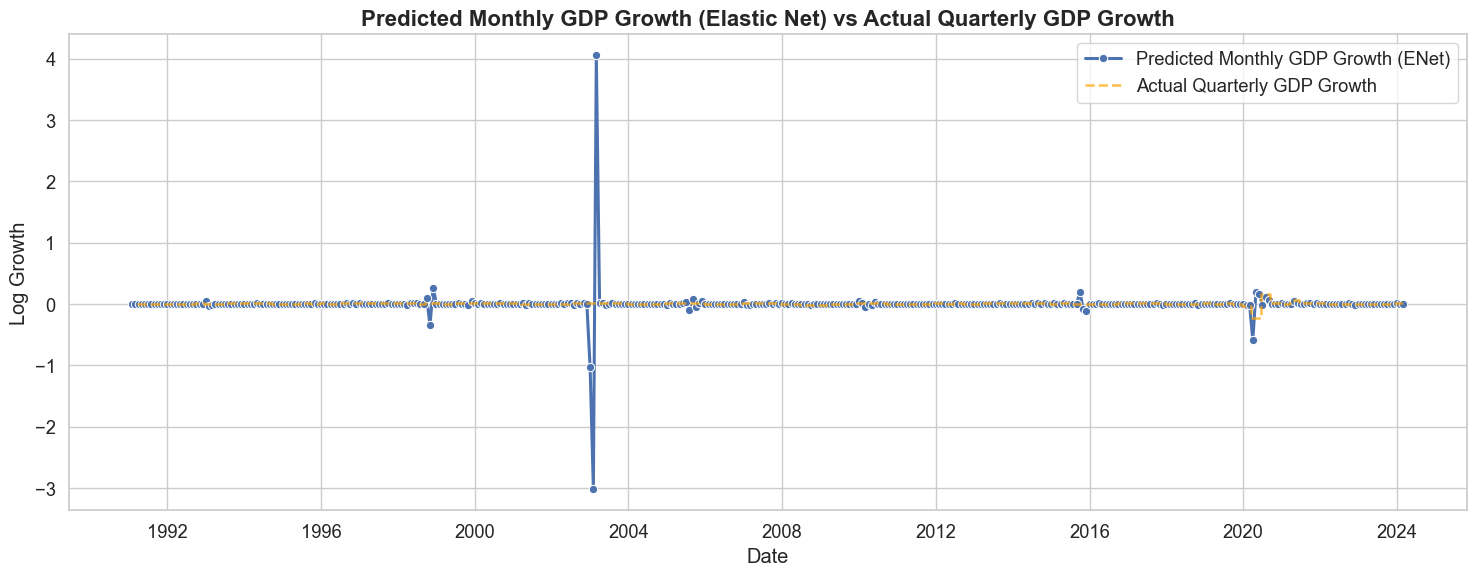

In [8]:
# Predicted monthly GDP growth (after reconciliation)
monthly_pred = monthly_predictions_df['adjusted_monthly_log_diff']

# Actual quarterly GDP growth, mapped to each month
quarter_to_growth = actual_quarterly_log_diffs
monthly_actual = monthly_predictions_df['quarter'].map(quarter_to_growth)

sns.set_theme(style="whitegrid", font_scale=1.2)

plt.figure(figsize=(15, 6))
sns.lineplot(x=monthly_pred.index, y=monthly_pred.values, label="Predicted Monthly GDP Growth (ENet)", marker='o', linewidth=2.2)
plt.step(monthly_actual.index, monthly_actual.values, label="Actual Quarterly GDP Growth",
         where='mid', linestyle='--', color='orange', linewidth=1.8, alpha=0.7)

plt.title("Predicted Monthly GDP Growth (Elastic Net) vs Actual Quarterly GDP Growth", fontsize=16, weight='bold')
plt.xlabel("Date")
plt.ylabel("Log Growth")
plt.legend()
plt.tight_layout()
plt.show()

Base quarter not found. Using the first available GDP level 1991Q1: 346292.0
Final quarterly comparison results:
            Actual_Quarterly_Level  ReAgg_Monthly_Level
quarter                                                
1991-01-01                346292.0        346292.000000
1991-04-01                345892.0        345790.655308
1991-07-01                345216.0        345257.609978
1991-10-01                345643.0        345773.243987
1992-01-01                345523.0        345344.405924

R²: 0.8572, MSE: 1105244073.06


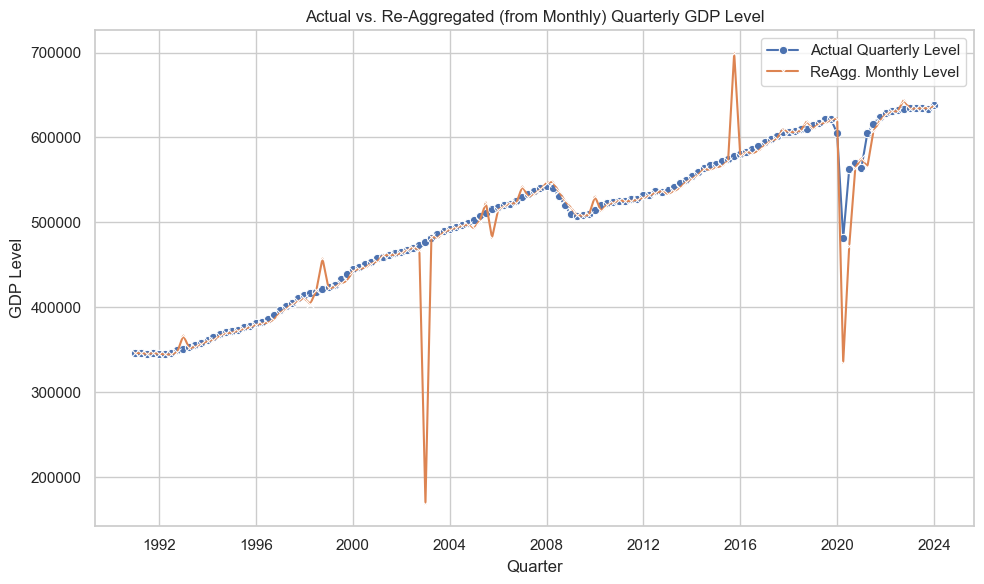

UK_monthly_GDP_ENET_growth_level.csv saved!


In [9]:
# Recover Monthly Level

# Find the first valid index (start month) for growth reconstruction
first_valid_month_idx = monthly_predictions_df['adjusted_monthly_log_diff'].first_valid_index()
first_quarter = monthly_predictions_df.loc[first_valid_month_idx, 'quarter']
base_level_quarter = first_quarter - 1

# Set base_level as the previous quarter's GDP level
if base_level_quarter in Y_q_levels.index:
    base_level = Y_q_levels.loc[base_level_quarter]
    print(f"Using GDP level of base quarter {base_level_quarter} as base_level: {base_level}")
else:
    base_level = Y_q_levels.iloc[0]
    print(f"Base quarter not found. Using the first available GDP level {Y_q_levels.index[0]}: {base_level}")

# Recover monthly GDP levels from growth (starting from the first valid growth)
reconstructed_levels = {}
current_level = base_level
for i, month in enumerate(monthly_predictions_df.index):
    if month < first_valid_month_idx:
        reconstructed_levels[month] = np.nan
    elif month == first_valid_month_idx:
        reconstructed_levels[month] = current_level
    else:
        log_diff = monthly_predictions_df.loc[month, 'adjusted_monthly_log_diff']
        if pd.isna(log_diff):
            reconstructed_levels[month] = np.nan
        else:
            prev_month = monthly_predictions_df.index[monthly_predictions_df.index.get_loc(month) - 1]
            prev_level = reconstructed_levels[prev_month]
            if pd.isna(prev_level):
                reconstructed_levels[month] = np.nan
            else:
                reconstructed_levels[month] = prev_level * np.exp(log_diff)
monthly_predictions_df['reconstructed_monthly_level'] = pd.Series(reconstructed_levels)


# Aggregate to Quarterly Level & Compare with Actual (using first month of each quarter)
monthly_predictions_df['quarter'] = monthly_predictions_df.index.to_period('Q')
re_agg_quarterly = (
    monthly_predictions_df
    .groupby('quarter')['reconstructed_monthly_level']
    .first()
)

# Convert index to Timestamp for plotting
re_agg_quarterly_ts = re_agg_quarterly.copy()
re_agg_quarterly_ts.index = re_agg_quarterly_ts.index.to_timestamp(how='start')
Y_q_levels_ts = Y_q_levels.copy()
Y_q_levels_ts.index = Y_q_levels_ts.index.to_timestamp(how='start')

comparison_df = pd.DataFrame({
    'Actual_Quarterly_Level': Y_q_levels_ts,
    'ReAgg_Monthly_Level': re_agg_quarterly_ts
}).dropna()

print("Final quarterly comparison results:")
print(comparison_df.head())
print("\nR²: %.4f, MSE: %.2f" % (
    r2_score(comparison_df['Actual_Quarterly_Level'], comparison_df['ReAgg_Monthly_Level']),
    mean_squared_error(comparison_df['Actual_Quarterly_Level'], comparison_df['ReAgg_Monthly_Level'])
))


# Plot 
sns.set_theme(style="whitegrid")
plt.figure(figsize=(10,6))
sns.lineplot(x=comparison_df.index, y=comparison_df['Actual_Quarterly_Level'], marker='o', label='Actual Quarterly Level')
sns.lineplot(x=comparison_df.index, y=comparison_df['ReAgg_Monthly_Level'], marker='x', label='ReAgg. Monthly Level')
plt.title("Actual vs. Re-Aggregated (from Monthly) Quarterly GDP Level")
plt.xlabel("Quarter")
plt.ylabel("GDP Level")
plt.legend()
plt.tight_layout()
plt.show()


# Save monthly GDP growth and level to CSV
out_df = pd.DataFrame({
    "MGDP_logdiff_pred": monthly_predictions_df['adjusted_monthly_log_diff'],
    "MGDP_level_pred": monthly_predictions_df['reconstructed_monthly_level']
}, index=monthly_predictions_df.index)
out_df.index.name = "DATE"
out_df.to_csv("UK_monthly_GDP_ENET_growth_level.csv")
print("UK_monthly_GDP_ENET_growth_level.csv saved!")